In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading dataset

In [2]:
import requests
from io import StringIO

# Fetch the data from GitHub
url = "https://raw.githubusercontent.com/chiru30/COMP-6321-Machine-Learning/main/major%20assignment%202/Question%201/AMZN.csv"
response = requests.get(url)
data = response.text

# Read the fetched data into a DataFrame
df = pd.read_csv(StringIO(data))

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500
6515,2023-04-05,103.910004,103.910004,100.750000,101.099998,101.099998,45103000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6516.000000,6516.000000,6516.000000,6516.000000,6516.000000,6.516000e+03
mean,31.611626,31.991995,31.193432,31.599740,31.599740,1.425338e+08
std,48.095343,48.659651,47.464476,48.060258,48.060258,1.401619e+08
min,0.070313,0.072396,0.065625,0.069792,0.069792,9.744000e+06
25%,1.998875,2.028500,1.964750,2.001250,2.001250,6.888182e+07
50%,6.456750,6.535500,6.353250,6.444250,6.444250,1.059050e+08
75%,38.451375,38.688000,38.203001,38.464625,38.464625,1.607700e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.086584e+09


In [7]:
data = df['Close']
data.head()

0    0.097917
1    0.086458
2    0.085417
3    0.081771
4    0.071354
Name: Close, dtype: float64

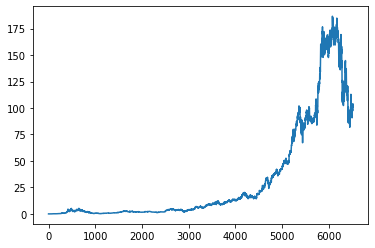

In [8]:
timeseries = data.values.astype('float32')

plt.plot(timeseries)
plt.show()

Preprocessing

In [9]:
import torch

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i + lookback]
        target = dataset[i + 1:i + lookback + 1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)


In [10]:
from sklearn.preprocessing import MinMaxScaler

lookback_size = 10
sequences, targets = create_dataset(timeseries, lookback_size)

# Reshape sequences and targets for LSTM input
sequences = sequences.reshape(-1, lookback_size, 1)
targets = targets.reshape(-1, lookback_size, 1)

# Normalize sequences and targets using MinMaxScaler
scaler = MinMaxScaler()
reshaped_sequences = scaler.fit_transform(sequences.reshape(-1, sequences.shape[-1]))
reshaped_targets = scaler.transform(targets.reshape(-1, targets.shape[-1]))

# Convert the reshaped sequences and targets to PyTorch tensors
X_tensor = torch.tensor(reshaped_sequences.reshape(-1, lookback_size, 1)).float()
y_tensor = torch.tensor(reshaped_targets.reshape(-1, lookback_size, 1)).float()

# Confirm the shapes of X and y tensors
print(f"X shape: {X_tensor.shape}, y shape: {y_tensor.shape}")


X shape: torch.Size([6506, 10, 1]), y shape: torch.Size([6506, 10, 1])


In [36]:
# # Assuming 'timeseries' is your time series data (numpy array)
# lookback_size = 10
# sequences, targets = create_dataset(timeseries, lookback_size)
# print(f"Targets Shape: {targets.shape}")  # Check the shape of the 'targets' variable


In [37]:
# import torch

# # Assuming 'timeseries' is your time series data (numpy array)
# lookback_size = 10
# sequences, targets = create_dataset(timeseries, lookback_size)

# # Convert the 'targets' tensor into sequences with the lookback size
# reshaped_targets = targets.unfold(0, len(targets) - lookback_size + 1, 1)
# reshaped_targets = reshaped_targets.reshape(-1, lookback_size)

# # Normalize the reshaped targets using MinMaxScaler
# scaler = MinMaxScaler()
# reshaped_targets_normalized = scaler.fit_transform(reshaped_targets)

# # Convert the reshaped and normalized targets to PyTorch tensor
# tensor_targets = torch.tensor(reshaped_targets_normalized, dtype=torch.float32)

# # Confirm the shape of the tensor targets
# print(f"Tensor Targets shape: {tensor_targets.shape}")


Model Training

In [11]:
import torch
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out


In [39]:
from torch.utils.data import TensorDataset, DataLoader

dataloader = data.DataLoader(data.TensorDataset(X_tensor, y_tensor), batch_size=8)

In [40]:
# Instantiate the LSTM model
model = LSTM(input_size=1, hidden_size=64, output_size=1, num_layers=2)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
# Training loop with DataLoader
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # inputs = inputs.unsqueeze(-1)  # Adding a dimension for LSTM input

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # # Reshape outputs and targets for loss calculation
        # batch_size = inputs.size(0)
        # outputs = outputs.view(batch_size, -1)  # Reshaping outputs
        # targets = targets.view(batch_size, -1)  # Reshaping targets

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [0/100], Loss: 0.0010
Epoch [1/100], Loss: 0.0009694189648143947
Epoch [2/100], Loss: 0.0012402350548654795
Epoch [3/100], Loss: 0.0012773151975125074
Epoch [4/100], Loss: 0.0019429198000580072
Epoch [5/100], Loss: 0.0023057505022734404
Epoch [6/100], Loss: 0.0012112399563193321
Epoch [7/100], Loss: 0.00027819868410006166
Epoch [8/100], Loss: 0.00033168247318826616
Epoch [9/100], Loss: 0.0007273567607626319
Epoch [10/100], Loss: 0.0010813577100634575
Epoch [10/100], Loss: 0.0014
Epoch [11/100], Loss: 0.0013602061662822962
Epoch [12/100], Loss: 0.0006043203175067902
Epoch [13/100], Loss: 0.0003609741397667676
Epoch [14/100], Loss: 0.0008774801972322166
Epoch [15/100], Loss: 0.0011530080810189247
Epoch [16/100], Loss: 0.0009296413627453148
Epoch [17/100], Loss: 0.0010163867846131325
Epoch [18/100], Loss: 0.0017847236013039947
Epoch [19/100], Loss: 0.0018397154053673148
Epoch [20/100], Loss: 0.0015517681604251266
Epoch [20/100], Loss: 0.0016
Epoch [21/100], Loss: 0.00156213226728141

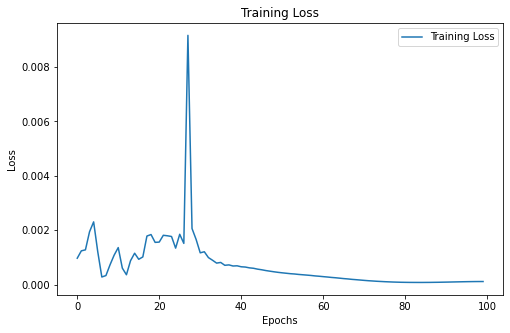

In [42]:
# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


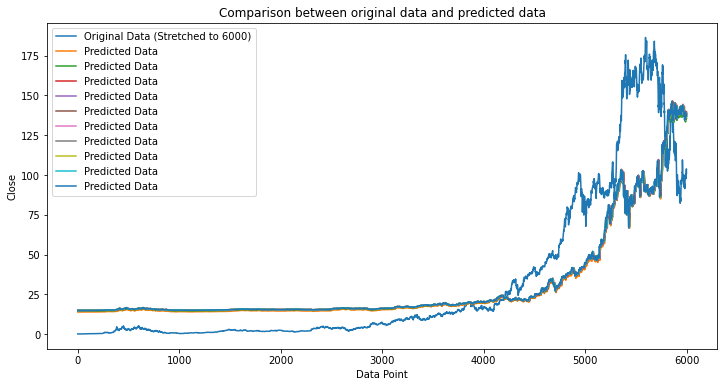

In [83]:
predictions = []

model.eval()
with torch.no_grad():
    test_loader = data.DataLoader(data.TensorDataset(X_tensor, y_tensor), batch_size=1)
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.detach().numpy().flatten())  # Flatten the sequences

# Assuming timeseries is the original data
# Stretch the original data to match the length of 6000
original_stretched = np.interp(np.linspace(0, 1, 6000), np.linspace(0, 1, len(timeseries)), timeseries)

# Calculate the range for plotting the predicted values
predicted_range = np.arange(len(original_stretched) - lookback_size + 1)

# Ensure predicted values match the length of the stretched original data
if len(predicted_values) > len(original_stretched):
    predicted_values = predicted_values[:len(original_stretched)]
elif len(predicted_values) < len(original_stretched):
    # Interpolate to match lengths
    predicted_values = np.interp(np.linspace(0, 1, len(original_stretched)), np.linspace(0, 1, len(predicted_values)), predicted_values)

# Plot the stretched original data and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(original_stretched, label='Original Data (Stretched to 6000)')
plt.plot(predicted_values, label='Predicted Data')
plt.xlabel('Data Point')
plt.ylabel('Close')
plt.title('Comparison between original data and predicted data')
plt.legend()
plt.show()

